## What does the order of a filter do?

One of the essential steps in signal processing is getting rid of unwanted noise from the signal. A signal could be composed of multiple frequency components. Real-life signal (signals from audio, video etc.) consists of various frequencies. 

This notebook would demonstrate signal denoising. First, I will take a clean signal consisting of only one frequency component. I will add noise to it. I will then filter the signal by removing unwanted frequencies.

In [1]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Utility Function

In [2]:
def create_sine_wave(freq, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates a sine wave with the given frequency, sampling rate, and length'''
    
    # if the total time in secs is None, then return one period of the wave
    if total_time_in_secs is None:
        total_time_in_secs = 1 / freq

    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    
    # Could also generate this signal by:
    # time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

    sine_wave = np.sin(2 * np.pi * freq * time)

    # or, once the sample is made:
    # time = np.linspace(0, len(s) / sampling_rate, num=len(s))

    if return_time is False:
        return sine_wave
    else:
        return (time, sine_wave)
    
    
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

Our noiseless signal contains only one frequency component, i.e. 50 Hz. We add noise to the clean signal by adding two additional frequency components, one of 70 Hz and 150 Hz.

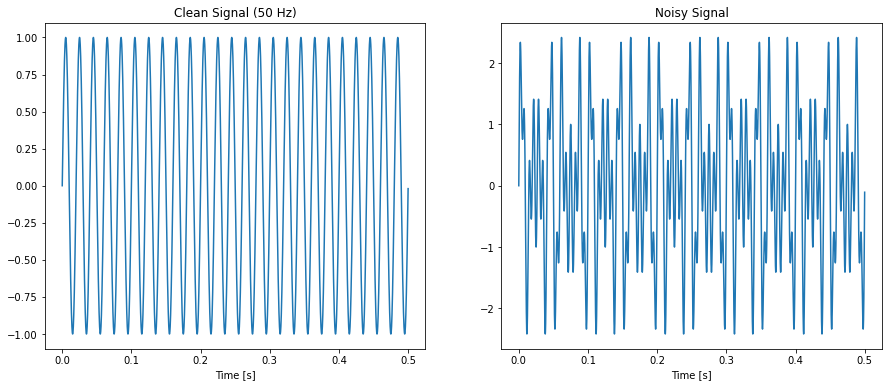

In [3]:
sampling_rate = 16000 
freq = 50 #original freq
total_time_in_secs = 0.5 # signal lasts 500ms
clean_signal = create_sine_wave(freq, sampling_rate, total_time_in_secs)
add_noise150 = create_sine_wave(150, sampling_rate, total_time_in_secs)
add_noise70 = create_sine_wave(70, sampling_rate, total_time_in_secs)
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
#add the signals and divide by the number of signals to normalise the final output.
signal = (clean_signal + add_noise150 + add_noise70)


fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(time, clean_signal)
ax[0].set_xlabel('Time [s]')
ax[0].set_title('Clean Signal (50 Hz)')
'''
ax[0,1].plot(time, add_noise70)
#ax[0,1].set_xlabel('Time [s]')
ax[0,1].set_title('Signal of 70 Hz')

ax[1,0].plot(time, add_noise150)
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_title('Signal of 150 Hz')
'''
ax[1].plot(time, signal)
ax[1].set_xlabel('Time [s]')
ax[1].set_title('Noisy Signal')

plt.show()


Our objective is to eliminate the noise from the noisy signal and restore it to the original (Clean) signal. We will first investigate what frequency components are present in the noisy signal. 

Text(0.5, 1.0, 'Frequency Response of the combined signal')

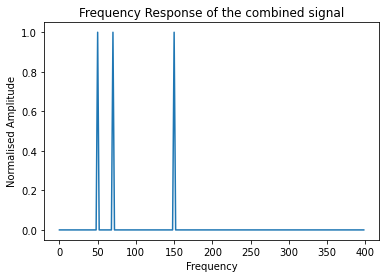

In [4]:
#observe the frequency components in the signal
fs, hs =compute_fft(signal, 16000, n = None, scale_amplitudes = True)
fig,ax=plt.subplots()
ax.plot(fs[:200],hs[:200])
ax.set_xlabel('Frequency')
ax.set_ylabel('Normalised Amplitude')
ax.set_title('Frequency Response of the combined signal')

In the plot above, we observe that the noisy signal consists of 50 Hz, 70 Hz and 150 Hz. Now, our objective is to design a filter to get rid of any frequency components other than 50 Hz (the frequency of the clean signal)

I designed an FIR (Butterworth Low Pass) filter (Using Python packages) to filter out unwanted noise components. I choose FIR over IIR because the hardware realisation of FIR is easier compared to IIR. 


Our cutoff frequency will be little more then 50 Hz to take care of the transition width between passband and stopband. I have set it to 55 Hz.

In [5]:
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

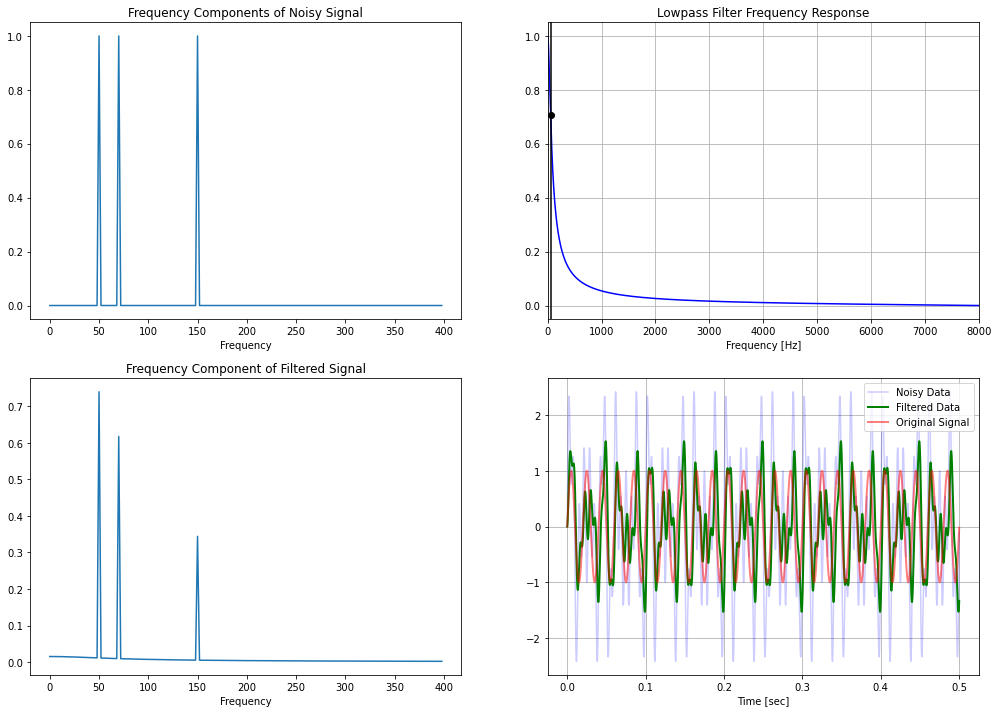

In [6]:
fs = 16000
cutoff = 55 # desired cutoff frequency of the filter, Hz
order = 1
y = butter_lowpass_filter(signal, cutoff, fs, order)

fig, ax = plt.subplots(2,2, figsize=(17,12))

#plot freq response of noisy signal
Fs, Hs =compute_fft(signal, 16000, n = None, scale_amplitudes = True)
ax[0,0].plot(Fs[:200],Hs[:200])
ax[0,0].set_title('Frequency Components of Noisy Signal')
ax[0,0].set_xlabel('Frequency')


# Plot the frequency response.
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
ax[0,1].plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax[0,1].plot(cutoff, 0.5*np.sqrt(2), 'ko')
ax[0,1].axvline(cutoff, color='k')
ax[0,1].set_xlim(0, 0.5*fs)
ax[0,1].set_title("Lowpass Filter Frequency Response")
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].grid()


Fs, Hs =compute_fft(y, 16000, n = None, scale_amplitudes = True)
ax[1,0].plot(Fs[:200],Hs[:200])
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,0].set_xlabel('Frequency')


ax[1,1].plot(time, signal, 'b-', label='Noisy Data', alpha=0.2)
ax[1,1].plot(time, y, 'g-', linewidth=2, label='Filtered Data')
ax[1,1].plot(time, clean_signal, 'r-', linewidth=2, label='Original Signal', alpha=0.5)
ax[1,1].set_xlabel('Time [sec]')
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,1].grid()
ax[1,1].legend()

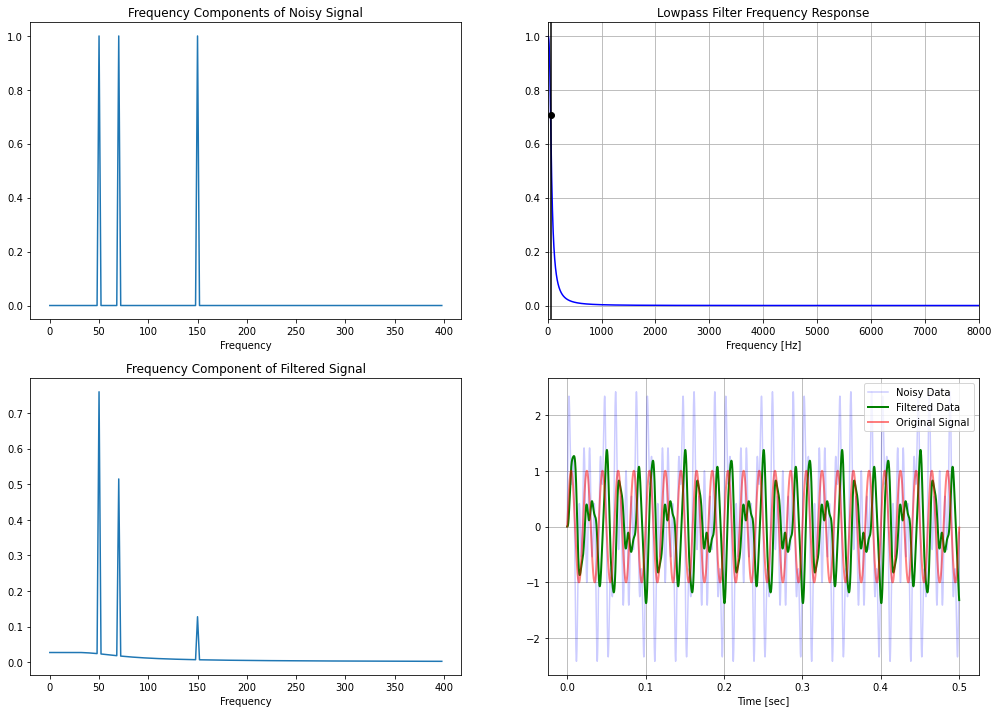

In [7]:
fs = 16000
cutoff = 55 # desired cutoff frequency of the filter, Hz
order = 2
y = butter_lowpass_filter(signal, cutoff, fs, order)

fig, ax = plt.subplots(2,2, figsize=(17,12))

#plot freq response of noisy signal
Fs, Hs =compute_fft(signal, 16000, n = None, scale_amplitudes = True)
ax[0,0].plot(Fs[:200],Hs[:200])
ax[0,0].set_title('Frequency Components of Noisy Signal')
ax[0,0].set_xlabel('Frequency')


# Plot the frequency response.
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
ax[0,1].plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax[0,1].plot(cutoff, 0.5*np.sqrt(2), 'ko')
ax[0,1].axvline(cutoff, color='k')
ax[0,1].set_xlim(0, 0.5*fs)
ax[0,1].set_title("Lowpass Filter Frequency Response")
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].grid()


Fs, Hs =compute_fft(y, 16000, n = None, scale_amplitudes = True)
ax[1,0].plot(Fs[:200],Hs[:200])
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,0].set_xlabel('Frequency')


ax[1,1].plot(time, signal, 'b-', label='Noisy Data', alpha=0.2)
ax[1,1].plot(time, y, 'g-', linewidth=2, label='Filtered Data')
ax[1,1].plot(time, clean_signal, 'r-', linewidth=2, label='Original Signal', alpha=0.5)
ax[1,1].set_xlabel('Time [sec]')
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,1].grid()
ax[1,1].legend()

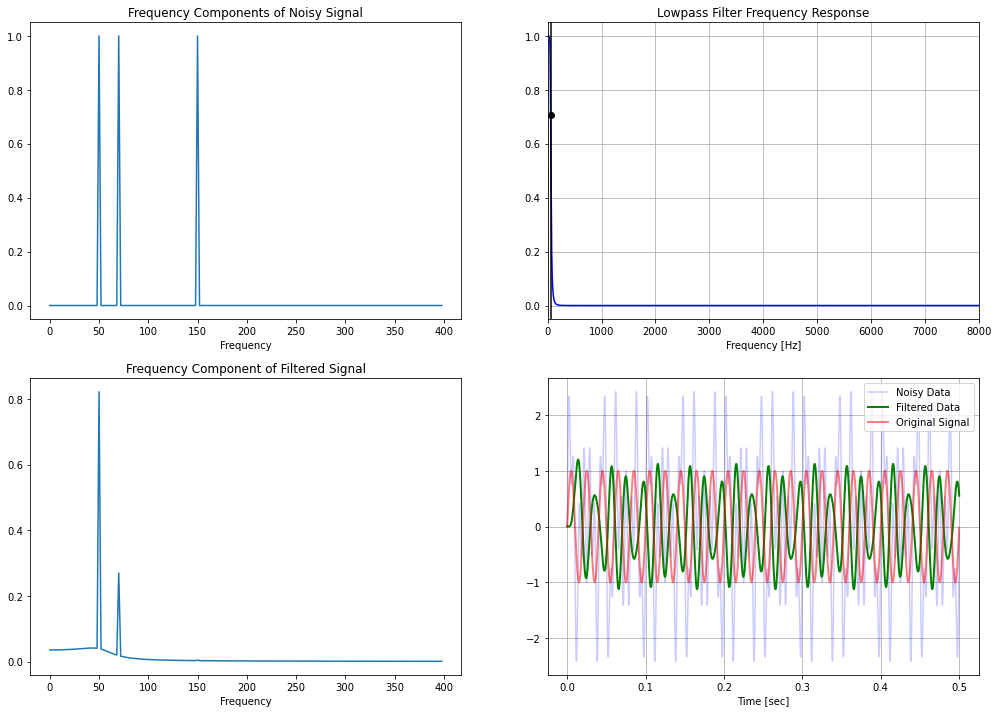

In [8]:
fs = 16000
cutoff = 55 # desired cutoff frequency of the filter, Hz
order = 5
y = butter_lowpass_filter(signal, cutoff, fs, order)

fig, ax = plt.subplots(2,2, figsize=(17,12))

#plot freq response of noisy signal
Fs, Hs =compute_fft(signal, 16000, n = None, scale_amplitudes = True)
ax[0,0].plot(Fs[:200],Hs[:200])
ax[0,0].set_title('Frequency Components of Noisy Signal')
ax[0,0].set_xlabel('Frequency')


# Plot the frequency response.
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
ax[0,1].plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax[0,1].plot(cutoff, 0.5*np.sqrt(2), 'ko')
ax[0,1].axvline(cutoff, color='k')
ax[0,1].set_xlim(0, 0.5*fs)
ax[0,1].set_title("Lowpass Filter Frequency Response")
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].grid()


Fs, Hs =compute_fft(y, 16000, n = None, scale_amplitudes = True)
ax[1,0].plot(Fs[:200],Hs[:200])
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,0].set_xlabel('Frequency')


ax[1,1].plot(time, signal, 'b-', label='Noisy Data', alpha=0.2)
ax[1,1].plot(time, y, 'g-', linewidth=2, label='Filtered Data')
ax[1,1].plot(time, clean_signal, 'r-', linewidth=2, label='Original Signal', alpha=0.5)
ax[1,1].set_xlabel('Time [sec]')
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,1].grid()
ax[1,1].legend()

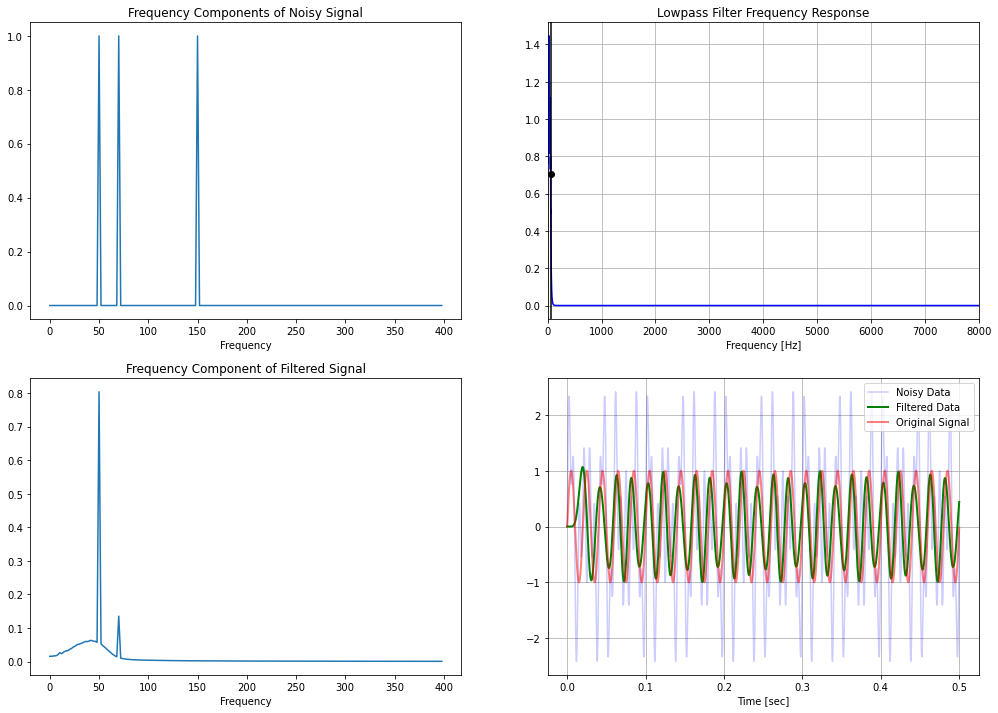

In [9]:
fs = 16000
cutoff = 55 # desired cutoff frequency of the filter, Hz
order = 8
y = butter_lowpass_filter(signal, cutoff, fs, order)

fig, ax = plt.subplots(2,2, figsize=(17,12))

#plot freq response of noisy signal
Fs, Hs =compute_fft(signal, 16000, n = None, scale_amplitudes = True)
ax[0,0].plot(Fs[:200],Hs[:200])
ax[0,0].set_title('Frequency Components of Noisy Signal')
ax[0,0].set_xlabel('Frequency')


# Plot the frequency response.
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
ax[0,1].plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax[0,1].plot(cutoff, 0.5*np.sqrt(2), 'ko')
ax[0,1].axvline(cutoff, color='k')
ax[0,1].set_xlim(0, 0.5*fs)
ax[0,1].set_title("Lowpass Filter Frequency Response")
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].grid()


Fs, Hs =compute_fft(y, 16000, n = None, scale_amplitudes = True)
ax[1,0].plot(Fs[:200],Hs[:200])
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,0].set_xlabel('Frequency')


ax[1,1].plot(time, signal, 'b-', label='Noisy Data', alpha=0.2)
ax[1,1].plot(time, y, 'g-', linewidth=2, label='Filtered Data')
ax[1,1].plot(time, clean_signal, 'r-', linewidth=2, label='Original Signal', alpha=0.5)
ax[1,1].set_xlabel('Time [sec]')
ax[1,0].set_title('Frequency Component of Filtered Signal')
ax[1,1].grid()
ax[1,1].legend()